In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Загрузка датасета
df = pd.read_csv('/content/drive/MyDrive/IMDB Dataset.csv')
df = df.sample(n=10000, random_state=42)

# Инициализация стеммера и списка стоп-слов
stemmer = SnowballStemmer('english')
stop_words = set(stopwords.words('english'))

# Предобработка текста
def preprocess_text(text):
    # Преобразование текста в нижний регистр
    text = text.lower()
    # Разделение текста на отдельные слова
    words = text.split()
    # Удаление стоп-слов и применение стемминга
    words = [stemmer.stem(word) for word in words if word not in stop_words]
    # Склеивание слов обратно в предложение
    text = ' '.join(words)
    return text

# Применение предобработки текста к датасету
df['processed_text'] = df['review'].apply(preprocess_text)

# Создание последовательности токенов
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['processed_text'])
sequences = tokenizer.texts_to_sequences(df['processed_text'])

# Максимальное количество слов в предложении
max_len = max([len(seq) for seq in sequences])

# Преобразование последовательностей в одинаковую длину
padded_sequences = pad_sequences(sequences, maxlen=max_len)

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout

# Создание модели
model = Sequential()
model.add(Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=128, input_length=max_len))
model.add(LSTM(128))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))

# Компиляция модели
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Вывод сводки модели
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 691, 128)          6394752   
                                                                 
 lstm_1 (LSTM)               (None, 128)               131584    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 6,526,465
Trainable params: 6,526,465
Non-trainable params: 0
_________________________________________________________________


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder
import numpy as np

# Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(padded_sequences, df['sentiment'], test_size=0.2, random_state=42)

# Кодирование меток в числовые значения
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Конвертирование кодированныех меток в float
y_train = np.asarray(y_train_encoded).astype('float32')
y_test = np.asarray(y_test_encoded).astype('float32')


In [ ]:
# Обучение модели
history = model.fit(X_train, y_train, batch_size=512, epochs=3, validation_data=(X_test, y_test))

Epoch 1/3
16/16 [==============================] - 176s 11s/step - loss: 0.6835 - accuracy: 0.6081 - val_loss: 0.6219 - val_accuracy: 0.7285
Epoch 2/3
16/16 [==============================] - 167s 10s/step - loss: 0.5505 - accuracy: 0.7746 - val_loss: 0.5372 - val_accuracy: 0.7620
Epoch 3/3
16/16 [==============================] - 176s 11s/step - loss: 0.3328 - accuracy: 0.8835 - val_loss: 0.3747 - val_accuracy: 0.8395


In [ ]:
model.save('lab7.h5')

In [ ]:
import tensorflow as tf

# Оценка модели
model = tf.keras.models.load_model('/content/drive/MyDrive/labz/lab7.h5')
predicted = model.predict(X_test)

predicted = [np.round(prediction) for prediction in predicted]
print(classification_report(y_test, predicted, target_names=["Negative", "Positive"]))

63/63 [==============================] - 27s 414ms/step
              precision    recall  f1-score   support

    Negative       0.85      0.82      0.84       999
    Positive       0.83      0.86      0.84      1001

    accuracy                           0.84      2000
   macro avg       0.84      0.84      0.84      2000
weighted avg       0.84      0.84      0.84      2000



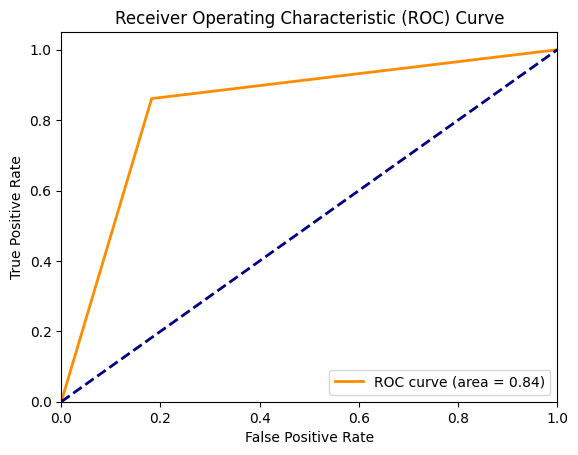

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

fpr, tpr, _ = roc_curve(y_test, predicted)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

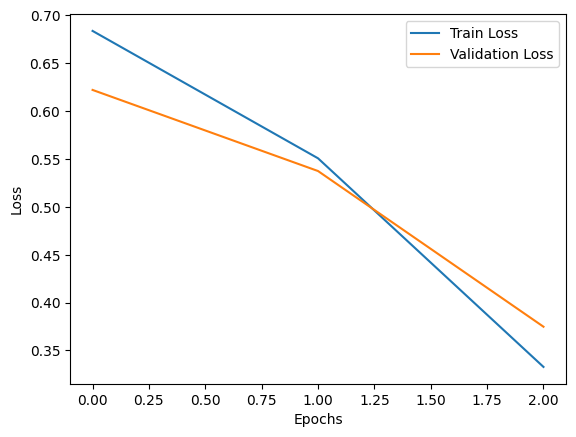

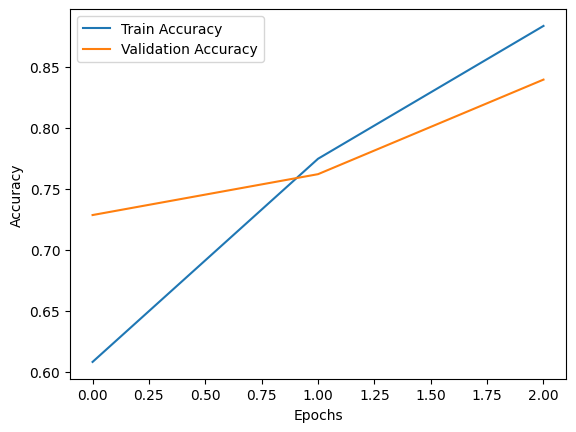

In [ ]:
import matplotlib.pyplot as plt

# График потерь
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# График точности
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
